In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta

from utils import *

c:\Users\azhe1\AppData\Local\Programs\Python\Python311\Lib\site-packages\py_lets_be_rational\numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


In [2]:
# S&P 500 Data
sp500 = pd.read_csv('sp500_data.csv', index_col='Date')
sp500.index = pd.to_datetime(sp500.index)

# Market-based Density Data
mbd = pd.read_csv('data\sp6m_6.csv', index_col='idt').iloc[:, 1:]
mbd.index = pd.to_datetime(mbd.index)

# risk-free rate
rf = pd.read_csv(r'data\risk_free.csv', index_col='DATE')
rf.index = pd.to_datetime(rf.index)

In [3]:
# Write a function that compute maturity date
def maturity_time(idt, maturity, trading_dates):
    maturity_dates = []
    for date in idt:
        # Add 6 months to the current date using relativedelta
        maturity_date = date + relativedelta(months=maturity)
        if maturity_date in trading_dates:
            maturity_dates.append(maturity_date)
        else:
            future_dates = [d for d in trading_dates if d > maturity_date]
            if future_dates:
                maturity_dates.append(future_dates[0])
            else:
                maturity_dates.append(None)
    return pd.to_datetime(maturity_dates)

# Compute maturity date
maturity_date = maturity_time(mbd.index, 6, sp500.index)

# Insert into mbd as a new column
mbd.insert(loc=2, column="maturity_date", value=maturity_date)
mbd.dropna(inplace=True)

# Append idt date price
idt_price = []
for i in mbd.index:
    if i not in sp500.index:
        idt_price.append(np.nan)
    else:
        idt_price.append(sp500.loc[i]['Close'])
mbd.insert(loc=1, column="idt_price", value=idt_price)

# Append maturity date price
maturity_date_price = np.array(sp500.loc[np.array(filter(lambda x: not pd.isna(x), maturity_date))]['Close'])
mbd['maturity_date_price'] = maturity_date_price
maturity_date_return = np.log(maturity_date_price / idt_price)
mbd['maturity_date_return'] = maturity_date_return

# Append risk-free rate at idt
mbd['risk_free_rate'] = np.sqrt(1 + np.array(pd.to_numeric(rf.loc[mbd.index]['DTB3'], errors='coerce').ffill())) / 100

In [4]:
# Simulate pdf to calculate probability
prob_mdr = []
prob_rf = []
prob_0 = []
for i in mbd.index:
    # Get pdf features
    rnp = mbd.loc[i]
    mu = rnp['mu']
    std = rnp['sd']
    skew = rnp['skew']
    kurt = rnp['kurt']
    rf = rnp['risk_free_rate']
    mdr = rnp['maturity_date_return']
    # Simulate prices based on risk-neutral prob
    try:
        N = 100000
        alpha = 0
        coef = fit_fleishman_from_sk(skew, kurt)
        sim = (generate_fleishman(-coef[1], *coef, N=N)) * std + mu
        # Calculate two prob: return > risk-free rate; return > 0
        cond_mdr = lambda x : x > mdr
        cond_rf = lambda x : x > (rf + alpha)
        cond_0 = lambda x : x > 0
        prob_mdr.append(sum(1 for e in sim if cond_mdr(e)) / N)
        prob_rf.append(sum(1 for e in sim if cond_rf(e)) / N)
        prob_0.append(sum(1 for e in sim if cond_0(e)) / N)
    except:
        print(f"Error at {i}")
        prob_mdr.append(np.nan)
        prob_rf.append(np.nan)
        prob_0.append(np.nan)

Error at 2020-03-18 00:00:00


In [5]:
mbd.ffill(inplace=True)
mbd.to_csv("mbd_updated.csv")

# Logistic Regression

In [6]:
mbd.columns

Index(['market', 'idt_price', 'maturity_target', 'maturity_date', 'mu', 'sd',
       'skew', 'kurt', 'p10', 'p50', 'p90', 'lg_change_decr', 'prDec',
       'lg_change_incr', 'prInc', 'maturity_date_price',
       'maturity_date_return', 'risk_free_rate'],
      dtype='object')

In [7]:
col = ['idt_price', 'mu', 'sd', 'skew', 'kurt', 'p10', 'p50', 'p90', 'lg_change_decr', 'prDec', 'lg_change_incr', 'prInc', 'risk_free_rate']
alpha = np.array(mbd['maturity_date_return'] - mbd['risk_free_rate'])
y = np.array([1 if a > 0 else 0 for a in alpha])
X = mbd.loc[:, col]

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train = X.iloc[:400, :]
y_train = y[:400]
X_test = X.iloc[400:, :]
y_test = y[400:]

scaler = StandardScaler()
clf = LogisticRegression(solver="liblinear", class_weight={0:1, 1:1}, penalty='l1', C=0.1)
name = "logistic_regression"
model_pipeline = Pipeline([("scaler", scaler), (name, clf)])

In [9]:
cross_val_score(model_pipeline, X_train, y_train, cv=5).mean()

0.6325

In [10]:
cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring="precision").mean()

0.6836111111111111

In [11]:
cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring="recall").mean()

0.8344827586206897

In [12]:
model_pipeline.fit(X_train, y_train)
confusion_matrix(y_train, model_pipeline.predict(X_train))

array([[ 36,  77],
       [  5, 282]], dtype=int64)

In [13]:
confusion_matrix(y_test, model_pipeline.predict(X_test))

array([[ 13,  77],
       [ 56, 114]], dtype=int64)

In [14]:
cross_val_score(model_pipeline, X_test, y_test, cv=5).mean()

0.6230769230769231

In [15]:
len( y_test)

260

In [16]:
confusion_matrix(y_test, model_pipeline.predict(X_test))

array([[ 13,  77],
       [ 56, 114]], dtype=int64)

In [17]:
X.columns

Index(['idt_price', 'mu', 'sd', 'skew', 'kurt', 'p10', 'p50', 'p90',
       'lg_change_decr', 'prDec', 'lg_change_incr', 'prInc', 'risk_free_rate'],
      dtype='object')

In [18]:
clf.coef_

array([[ 0.        , -0.39535385,  0.        ,  0.        ,  0.44639781,
         0.        , -0.21000241,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.1148552 ]])

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\azhe1\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\azhe1\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:

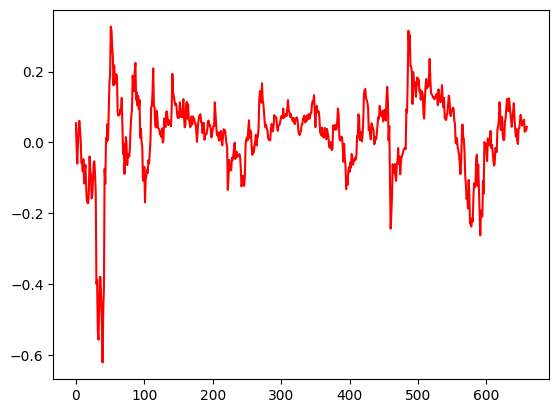

In [19]:
x = list(range(660))
# plt.plot(x, np.array(prob_rf)-0.5)
# plt.plot(x, mbd['mu'], color='green')
plt.plot(x, mbd['maturity_date_return']-mbd['risk_free_rate'], color='r')

In [20]:
mbd['mu'][mbd['mu'] < 0]

idt
2008-02-15   -0.004028
2008-02-29   -0.004291
2008-03-14   -0.009444
2008-03-31   -0.004959
2008-04-15   -0.002104
                ...   
2022-03-02   -0.001380
2022-03-09   -0.000740
2022-05-11   -0.002240
2022-05-18   -0.000610
2022-05-25   -0.000860
Name: mu, Length: 359, dtype: float64